## GWpy Examples

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import pandas as pd
from numpy import random
from gwpy.timeseries import TimeSeries
from gwpy.plot import Plot
import gwosc

os.environ['GWPY_CACHE'] = '1'  # autocache

# event = 'GW150914'
# start = gwosc.datasets.event_gps(event)
# length = noise.dt.value*len(noise)
# open_data = TimeSeries.fetch_open_data('H1', start, start + length)

## Filtering a `TimeSeries` to detect gravitational waves

https://gwpy.github.io/docs/stable/examples/signal/gw150914.html

The raw 'strain' output of the LIGO detectors is recorded as a `TimeSeries` with contributions from a large number of known and unknown noise sources, as well as possible gravitational wave signals.

In order to uncover a real signal we need to filter out noises that otherwise hide the signal in the data. We can do this by using the `gwpy.signal` module to design a digital filter to cut out low and high frequency noise, as well as notch out fixed frequencies polluted by known artefacts.

In [6]:
hdata = TimeSeries.fetch_open_data('H1', 1126259446, 1126259478, verbose=True)  # raw strain data from GWOSC public archive

Fetched 1 URLs from www.gw-openscience.org for [1126259446 .. 1126259478))
Reading data... [Done]


Next we can design a zero-pole-gain filter to remove the extranious noise.

First we import the `gwpy.signal.filter_design` module and create a `bandpass()` filter to remove both low and high frequency content.

Then we want to combine the bandpass with a series of `notch()` filters, so we create those for the first three harmonics of the 60Hz AC mains power, and then concatenate each filter together to create a single ZPK:

In [7]:
from gwpy.signal import filter_design
bandpass = filter_design.bandpass(50, 250, hdata.sample_rate)

notches = [filter_design.notch(line, hdata.sample_rate) for line in (60, 120, 180)]
zpk = filter_design.concatenate_zpks(bandpass, *notches)

In [8]:
# now we apply our combined filter to the data
hfilt = hdata.filter(zpk, filtfilt=True)

The `filter_design` methods return infinite impulse response filters by default, which, when applied, corrupt a small amount of data at the beginning and the end of our original `TimeSeries`. We can discard those data using the `crop()` method (for consistency we apply this to both data series):

In [9]:
hdata = hdata.crop(*hdata.span.contract(1))
hfilt = hfilt.crop(*hfilt.span.contract(1))

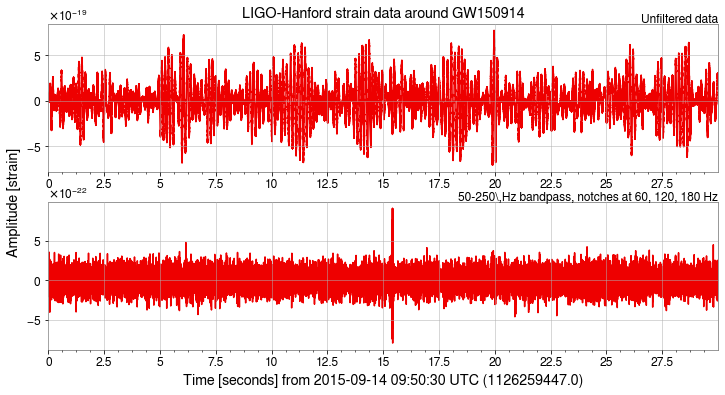

In [10]:
# display original and filtered data
plot = Plot(hdata, hfilt, figsize=(12,6), separate=True, sharex=True, color='gwpy:ligo-hanford')
ax1, ax2 = plot.axes
ax1.set_title('LIGO-Hanford strain data around GW150914')
ax1.text(1.0, 1.01, 'Unfiltered data', transform=ax1.transAxes, ha='right')
ax1.set_ylabel('Amplitude [strain]', y=-0.2)
ax2.set_ylabel('')
ax2.text(1.0, 1.01, r'50-250\,Hz bandpass, notches at 60, 120, 180 Hz', transform=ax2.transAxes, ha='right')
plot.show()

We can see a spike at approximately 16 seconds into the data, so we can zoom in as follows:

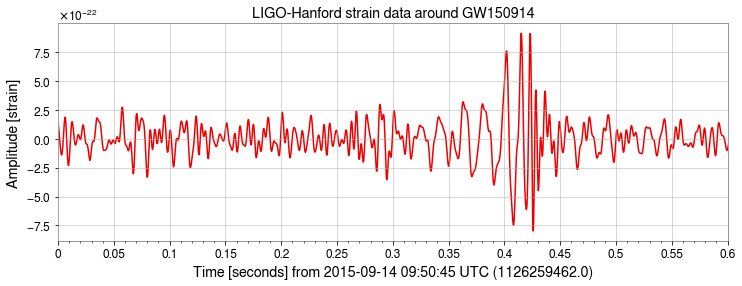

In [17]:
plot = hfilt.plot(color='gwpy:ligo-hanford')
ax = plot.gca()
ax.set_title('LIGO-Hanford strain data around GW150914')
ax.set_ylabel('Amplitude [strain]')
ax.set_xlim(1126259462, 1126259462.6)
ax.set_xscale('seconds', epoch=1126259462)
plot.show()

Congratulations, you have succesfully filtered LIGO data to uncover the first ever directly-detected gravitational wave signal, GW150914! But wait, what about LIGO-Livingston? We can easily add that to our figure by following the same procedure.

The article announcing the detector told us that the signals were separated by 6.9 ms between detectors, and that the relative orientation of those detectors means that we need to invert the data from one before comparing them, so we apply those corrections:

In [22]:
ldata = TimeSeries.fetch_open_data('L1', 1126259446, 1126259478)
lfilt = ldata.filter(zpk, filtfilt=True)

lfilt.shift('6.9ms')
lfilt *= -1

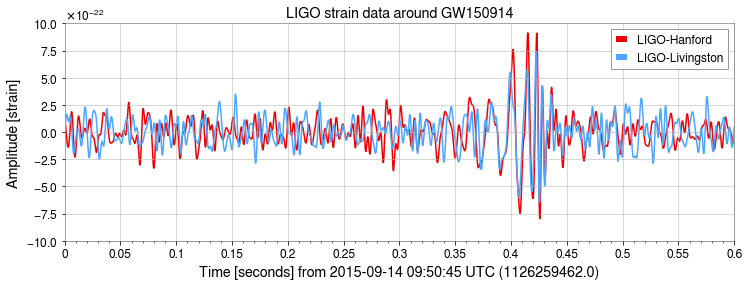

In [23]:
plot = Plot(figsize=(12,4))
ax = plot.gca()
ax.plot(hfilt, label='LIGO-Hanford', color='gwpy:ligo-hanford')
ax.plot(lfilt, label='LIGO-Livingston', color='gwpy:ligo-livingston')
ax.set_title('LIGO strain data around GW150914')
ax.set_xlim(1126259462, 1126259462.6)
ax.set_xscale('seconds', epoch=1126259462)
ax.set_ylabel('Amplitude [strain]')
ax.set_ylim(-1e-21, 1e-21)
ax.legend()
plot.show()

## Other Tutorial Examples

### 1. Plotting public LIGO data

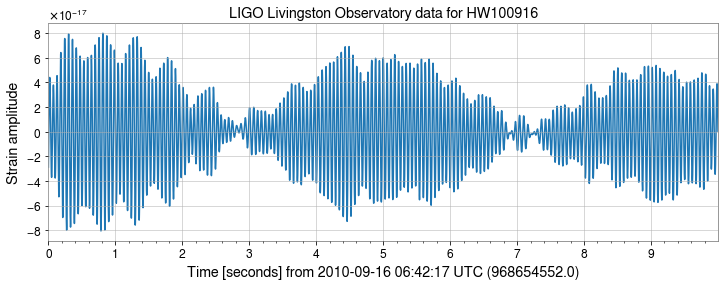

In [3]:
data = TimeSeries.fetch_open_data('L1', 968654552, 968654562)
plot = data.plot(
    title='LIGO Livingston Observatory data for HW100916',
    ylabel='Strain amplitude')
plot.show()

### 2. Filtering a TimeSeries with a ZPK filter

Several data streams read from the LIGO detectors are whitened before being recorded to prevent numerical errors when using single-precision data storage. In this example we read such `channel` and undo the whitening to show the physical content of these data.


Note: The Amplitude Spectral Density (ASD) is the square root of the Power Spectral Density (PSD); and the ASD of a voltage signal has units of ${V{Hz}^-{1/2}}$.

The power spectrum of a time series describes the distribution of power into frequency components composing that signal. When the energy of the signal is concentrated around a finite time interval, especially if its total energy is finite, one may compute the **energy spectral density**.

More commonly used is the **power spectral density** (or power spectrum) which applies to signals existing over *all* time, or over a time period large enough relative to the measurement duration such that the interval may as well have been an infinite time interval. The PSD then refers to the spectral energy distribution that would be found per unit time, since the total energy of such a signal over all time would generally be infinite.

Now, we can re-calibrate these data into displacement units by first applying a `highpass` filter to remove the low-frequency noise, and then appling our de-whitening filter in `ZPK` format with five zeros at 100 Hz and five poles at 1 Hz (giving an overall DC gain of $10^{-10}$).

In [ ]:
# from datetime import datetime

# start = datetime.strptime('March 2 2015 12:00', '%B %d %Y %H:%M').timestamp()
# end = datetime.strptime('March 2 2015 12:30', '%B %d %Y %H:%M').timestamp()
# white = TimeSeries.fetch_open_data('L1', start, end, verbose=True)

# as we do not have a LIGO KEY we can only access data through fetch_open_data

from gwpy.plot import Plot
hp = data.highpass(4)  # we just use data as an example
displacement = hp.zpk([100]*5, [1]*5, 1e-10)

whiteasd = data.asd(8, 4)
dispasd = displacement.asd(8, 4)

plot = Plot(asd, dispasd, separate=True, sharex=True, xscale='log', yscale='log')
plot.axes[0].set_ylabel('ASD [whitened]')
plot.axes[1].set_ylabel(r'ASD [m/$\sqrt{\mathrm{Hz}}$]')
plot.axes[1].set_xlabel('Frequency [Hz]')
plot.axes[1].set_ylim(1e-20, 1e-15)
plot.axes[1].set_xlim(5, 4000)
plot.show()

### 6. Plotting segments for a `StateVector`

In [3]:
from gwpy.timeseries import StateVector

state = StateVector.fetch_open_data('L1', 968654552, 968654562, verbose=True, tag='C00')
plot = state.plot(insetlabels=True)
ax = plot.gca()
ax.set_xscale('seconds', epoch=1187008882)
ax.axvline(1187008882, color='orange', linestyle='--')
ax.set_title('LIGO-Livingston data quality around GW170817')
plot.show()

Fetched 1 URLs from www.gw-openscience.org for [968654552 .. 968654562))
Reading data... [Done]


### 7. Generate the Q-transform of a `TimeSeries`

In [5]:
from gwpy.timeseries import TimeSeries
data = TimeSeries.fetch_open_data('H1', 1126259446, 1126259478)
qspecgram = data.q_transform(outseg=(1126259462.2, 1126259462.5))

plot = qspecgram.plot(figsize=(8,4))
ax = plot.gca()
ax.set_xscale('seconds')
ax.set_yscale('log')
ax.set_ylim(20, 500)
ax.set_ylabel('Frequency [Hz]')
ax.grid(True, axis='y', which='both')
ax.colorbar(cmap='viridis', label='Normalized energy')
plot.show()

/home/dawn/miniconda3/envs/astro/lib/python3.8/site-packages/gwpy/plot/plot.py:395: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = super().colorbar(mappable, **kwargs)


### 8. Calculating the SNR associated with a given astrophysical signal model

An astrophysical search algorithm detects signals by calculating the signal-to-noise ratio (SNR) of data for each in a large bank of signal models, known as templates (a process known as matched filtering).

We can replicate this search process using `pycbc`.

In [24]:
from gwpy.timeseries import TimeSeries
data = TimeSeries.fetch_open_data('H1', 1126259446, 1126259478)

# it is important to apply a highpass filter (e.g. at 15Hz) to remove noise at lower frequencies that
# aren't accurately calibrated, and swamps smaller noises at higher frequencies.
high = data.highpass(15)

# we want to calculate the SNR over a 4 second segment, so we calculate a PSD with a 4 second FFT
# (using all the data), and then crop it to the 4 seconds we would like
psd = high.psd(4, 2)
zoom = high.crop(1126259460, 1126259464)

In order to calculate signal-to-noise ratio, we need a signal model against which to compare our data. For this we import `pycbc.waveform.get_fd_waveform` and generate a template as a `pycbc.types.FrequencySeries`:

In [26]:
from pycbc.waveform import get_fd_waveform
hp, _ = get_fd_waveform(
    approximant='IMRPhenomD',
    mass1=40,
    mass2=32,
    f_lower=20,
    f_final=2048,
    delta_f=psd.df.value,
)

At this point we are ready to calculate the SNR, so we import the `pycbc.filter.matched_filter` method, and pass it our waveform template, the data, and the PSD:

In [27]:
from pycbc.filter import matched_filter
snr = matched_filter(hp, zoom.to_pycbc(), psd=psd.to_pycbc(), low_frequency_cutoff=15)
snr_timeseries = TimeSeries.from_pycbc(snr).abs()  # "SNR" timeseries is a signal correlation timeseries

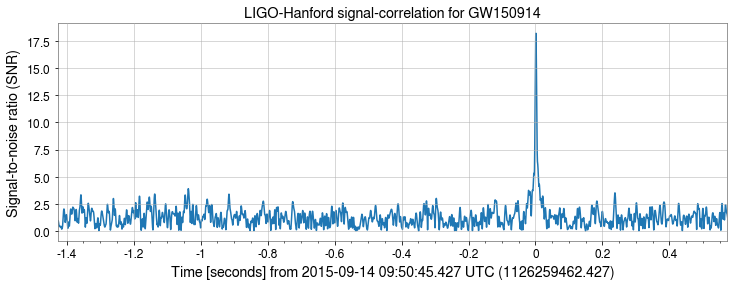

In [28]:
plot = snr_timeseries.plot()
ax = plot.gca()
ax.set_xlim(1126259461, 1126259463)
ax.set_epoch(1126259462.427)
ax.set_ylabel('Signal-to-noise ratio (SNR)')
ax.set_title('LIGO-Hanford signal-correlation for GW150914')
plot.show()

### 9. Inject a known signal into a `TimeSeries`


In [ ]:
from astropy.utils.data import get_readable_fileobj
url = ("https://www.gw-openscience.org/s/events/GW150914/P150914/fig2-unfiltered-waveform-H.txt")

with get_readable_fileobj(url) as f:
    signal = TimeSeries.read(f, format='txt')

# make sure this intersects with noise time samples
signal.t0 = .5

# since this simulation cuts off before a certain time
# it is important to taper its ends to zero to avoid ringing artifacts.
signal = signal.taper()

# prepare one second of gaussian white noise
noise = TimeSeries(random.normal(scale=.1, size=16384), sample_rate=16384)

data = noise.inject(signal)

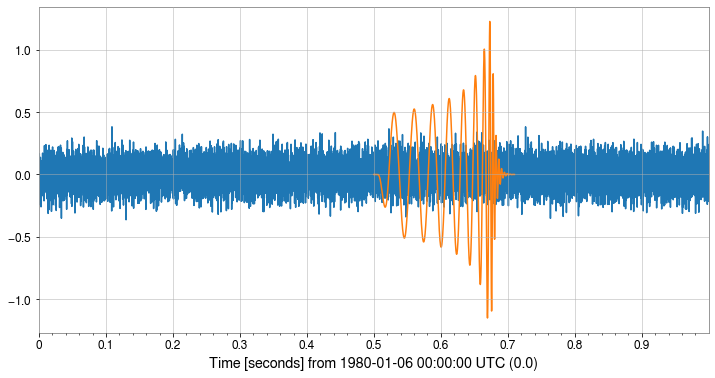

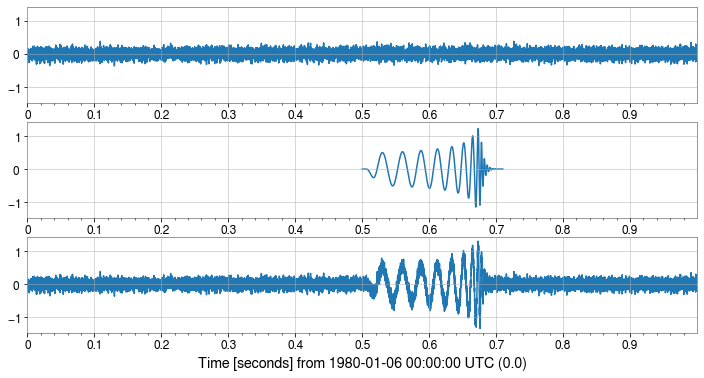

In [21]:
from gwpy.plot import Plot
plot = Plot(noise, signal, sharex=True, sharey=True)
plot.gca().set_epoch(0)
plot.show()

plot = Plot(noise, signal, data, separate=True, sharex=True, sharey=True)
plot.gca().set_epoch(0)
plot.show()

In [30]:
from gwpy.table import EventTable
events = EventTable.fetch_open_data('GWTC-1-confident')

In [41]:
# gps times for events in GWTC-1-confident
events['GPS'].data.data

array([1.12625946e+09, 1.12867890e+09, 1.13513635e+09,
       1.16755994e+09, 1.18092249e+09, 1.18538981e+09,
       1.18630252e+09, 1.18674186e+09, 1.18700888e+09,
       1.18705833e+09, 1.18752926e+09])

In [71]:
# https://lscsoft.docs.ligo.org/ligo.skymap/coordinates/detector.html
from astropy.coordinates import EarthLocation
help(EarthLocation.of_site('H1'))

Help on EarthLocation in module astropy.coordinates.earth object:

class EarthLocation(astropy.units.quantity.Quantity)
 |  EarthLocation(*args, **kwargs)
 |  
 |  Location on the Earth.
 |  
 |  Initialization is first attempted assuming geocentric (x, y, z) coordinates
 |  are given; if that fails, another attempt is made assuming geodetic
 |  coordinates (longitude, latitude, height above a reference ellipsoid).
 |  When using the geodetic forms, Longitudes are measured increasing to the
 |  east, so west longitudes are negative. Internally, the coordinates are
 |  stored as geocentric.
 |  
 |  To ensure a specific type of coordinates is used, use the corresponding
 |  class methods (`from_geocentric` and `from_geodetic`) or initialize the
 |  arguments with names (``x``, ``y``, ``z`` for geocentric; ``lon``, ``lat``,
 |  ``height`` for geodetic).  See the class methods for details.
 |  
 |  
 |  Notes
 |  -----
 |  This class fits into the coordinates transformation framework in t

In [74]:
h1_loc = EarthLocation.of_site('H1').to_geodetic()
h1_loc

GeodeticLocation(lon=<Longitude -119.40765714 deg>, lat=<Latitude 46.45514667 deg>, height=<Quantity 142.55400086 m>)

In [80]:
from astropy.time import Time
from datetime import datetime
h1_loc = EarthLocation.of_site('H1').to_geodetic()
loc_coordinates = (f'{h1_loc.lon.value}d', f'{h1_loc.lat.value}d')
t = Time(datetime.utcnow(), scale='utc', location=loc_coordinates)

In [83]:
help(t.sidereal_time)

Help on method sidereal_time in module astropy.time.core:

sidereal_time(kind, longitude=None, model=None) method of astropy.time.core.Time instance
    Calculate sidereal time.
    
    Parameters
    ---------------
    kind : str
        ``'mean'`` or ``'apparent'``, i.e., accounting for precession
        only, or also for nutation.
    longitude : `~astropy.units.Quantity`, `str`, or `None`; optional
        The longitude on the Earth at which to compute the sidereal time.
        Can be given as a `~astropy.units.Quantity` with angular units
        (or an `~astropy.coordinates.Angle` or
        `~astropy.coordinates.Longitude`), or as a name of an
        observatory (currently, only ``'greenwich'`` is supported,
        equivalent to 0 deg).  If `None` (default), the ``lon`` attribute of
        the Time object is used.
    model : str or `None`; optional
        Precession (and nutation) model to use.  The available ones are:
        - apparent: ['IAU1994', 'IAU2000A', 'IAU200

In [85]:
t.sidereal_time('apparent')

<Longitude 15.40471325 hourangle>

In [86]:
t.sidereal_time('mean')

<Longitude 15.40500993 hourangle>